# Grilla 4-d: A, k, sigma, gamma

## Environment

In [1]:
import gym
import numpy as np
import math
# make the simulation into an RL environment:
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from runstats import *
import runstats
import pandas as pd
from itertools import product

np.random.seed(1234)

c:\1_Projects\Tesis Quant UdeSA\optimal-market-making-main\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Fixed Parameters

In [2]:
s0 = 100
T = 1. # Total time.
dt = .005  # Time step.

In [3]:
# MS: Using a discrete action space similar to the Market Making via Reinforcement Learning paper (https://arxiv.org/pdf/1804.04216.pdf, Section 3 - p.3)
actions_num = 21   #MS: So the range of possibilities goes from 0.3% to 3% from TOB
max_abs_dif = 4
max_abs_spread = 20

def spread(beta, sigma, T_t, k):
    return beta*sigma**2*(T_t) + 2/beta*np.log(1+beta/k)

def r(beta, sigma, T_t, s, q):
    return s - q*beta*sigma**2*(T_t)

def l(A, k, d):
    '''
    Parameters
    ----------
      A : float
        in Avellaneda A = \lambda/\alpha, where alpha is as above,
        and lambda is the constant frequency of market buy and sell orders.
      k : float
        in Avellaneda k = alpha*K, where alpha ~ 1.5, 
        and K is such that \delta p ~ Kln(Q) for a market order of size Q
      d : float
        in Avellaneda, d=distance to the mid price
    
    Return
    -------
    
      l : float:
        in Avellaneda, l = lambda = Poisson intensity at which our agent’s orders are
        executed.
    '''
    return A*np.exp(-k*d) 
    #JK: eq. (12)    


class AvellanedaEnv:
    def __init__(self, s0, T, dt, sigma, beta, k, A, kappa, seed=0, is_discrete=True):
        '''
        Parameters
        ----------
        s : float
            Initial value of future/stock price.
        b : float
            Initial value of 'brecha'.
        T : float
            Total time.
        dt : float
            Time subdivision.
        sigma : float
            price volatility.
        gamma : float
            discount factor.
        k : float
            in Avellaneda k = alpha*K, where alpha ~ 1.5, 
            and K is such that \delta p ~ Kln(Q) for a market order of size Q
        A : float
            in Avellaneda A = \lambda/\alpha, where alpha is as above,
            and lambda is the constant frequency of market buy and sell orders.
    
        '''
        self.s0 = s0
        self.T = T
        self.dt = dt
        self.sigma = sigma
        self.beta = beta
        self.k = k
        self.A = A
        self.sqrtdt = np.sqrt(dt)
        self.kappa = kappa
        self.is_discrete = is_discrete
        self.stats = runstats.ExponentialStatistics(decay=0.999)
        np.random.seed(seed)

        # observation space: s (price), q, T-t (time remaining)
        self.observation_space = gym.spaces.Box(low=np.array([0.0, -math.inf, 0.0]),
                                     high=np.array([math.inf, math.inf,T]),
                                     dtype=np.float32)
        # action space: spread, ds
        self.action_space = gym.spaces.Discrete(actions_num)
        self.reward_range = (-math.inf,math.inf)
        
        self.metadata = None # useless field
        
    def reset(self,seed=0):
        self.s = self.s0
        self.q = 0.0
        self.t = 0.0
        self.w = 0.0
        self.n = int(T/dt)
        self.c_ = 0.0
        return np.array((self.s,self.q,self.T))
        
    def step(self, action):
        if self.is_discrete:
            despl = (action-(actions_num-1)/2)*max_abs_dif/(actions_num-1)
        else:
            despl = action
        ba_spread = spread(self.beta,self.sigma,self.T-self.t,self.k)

        bid = self.s - despl - ba_spread/2
        ask = self.s - despl + ba_spread/2
                
        db = self.s - bid
        da = ask - self.s
        
        lb = l(self.A, self.k, db)
        la = l(self.A, self.k, da)
        
        dnb = 1 if np.random.uniform() <= lb * self.dt else 0
        dna = 1 if np.random.uniform() <= la * self.dt else 0
        self.q += dnb - dna

        self.c_ += -dnb * bid + dna * ask # cash

        self.s += self.sigma * self.sqrtdt *(1 if np.random.uniform() < 0.5 else -1)

        previous_w = self.w
        self.w = self.c_ + self.q * self.s
                
        dw = (self.w - previous_w)
        self.stats.push(dw)
        #reward =  np.exp(-self.gamma*previous_w) - np.exp(-self.gamma*self.w) - 1/(self.n)
        
        #if self.t >= self.T:
        reward = dw - self.kappa/2 * (dw - self.stats.mean())**2
        
        #if self.t >= self.T - self.dt:
            #print("sum of dw: " + str(sum(self.ws)))
            #print("sum of kappa/2 * (dw - mu)**2: " + str(sum(self.rews)))
        
        self.t += self.dt

            
        return np.array((self.s,self.q,self.T-self.t)), reward, self.t >= self.T, {'w':self.w}
    
# env = AvellanedaEnv(s0, T, dt, sigma, beta, k, A,kappa)



## Agents

### RL Agent

In [4]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 25364), started 1 day, 5:45:50 ago. (Use '!kill 25364' to kill it.)

In [5]:
from stable_baselines3 import PPO, DQN, A2C

# Load best model!
model = DQN.load("./logs/best_model.zip")

### Avellaneda Agent

In [6]:
# optimal policy agent as per Avellaneda

def spread_func(beta, sigma, k):
    return lambda T_t: spread(beta, sigma, T_t, k) 

def r_func(sigma, beta):
    return lambda T_t, s, q: r(beta, sigma, T_t, s, q)
    
class AvellanedaAgent:
    def __init__(self, beta, sigma, k):
        self.spread_func = spread_func(beta, sigma, k)
        self.r_func = r_func(sigma, beta)
        
    def act(self, observation):
        spread = self.spread_func(observation[2])
        r_ = self.r_func(observation[2], observation[0], observation[1])
        
        bid = r_ - spread/2
        ask = r_ + spread/2

        ds = observation[0] - r_
        
        #return spread, ds
        return ds

    def step(self,observation):
        return self.act(observation)

#agent = AvellanedaAgent(gamma, sigma, k)

### Symetrical Agent

In [7]:
# symmetrical policy agent as per Avellaneda

class SymmetricAgent:
    def __init__(self, beta, sigma, k):
        self.spread_func = spread_func(beta, sigma, k)
        
    def act(self, observation):
        #spread = self.spread_func(observation[2])
        return 0

    def step(self,observation):
        return self.act(observation)

#symmetric_agent = SymmetricAgent(gamma, sigma, k)

## Simulations

In [8]:
def run_env_agent_comp(envs, agent_rl,agent_opt,agent_sym):
    
    env = envs[0]
    
    obs = env.reset()
    bids_rl = np.zeros(env.n)
    asks_rl = np.zeros(env.n)
    ss_rl = np.zeros(env.n)
    ws_rl = np.zeros(env.n)
    qs_rl = np.zeros(env.n)
    final = False
    i = 0

    total_reward_rl = 0.0
    while not final:

        action_rl = agent_rl.predict(obs,deterministic=True)
        ss_rl[i] = obs[0]
        qs_rl[i] = obs[1]
        
        despl = (action_rl[0]-(actions_num-1)/2)*max_abs_dif/(actions_num-1)
        ba_spread = spread(env.beta,env.sigma,env.T-env.t,env.k)

        bids_rl[i] = ss_rl[i] - despl - ba_spread/2
        asks_rl[i] = ss_rl[i] - despl + ba_spread/2

        obs, reward, final, w_rl = env.step(action_rl[0])
        i += 1
        total_reward_rl += reward

      
    

    env = envs[1]
    
    obs = env.reset()
    bids_opt = np.zeros(env.n)
    asks_opt = np.zeros(env.n)
    ds_opt = np.zeros(env.n)
    spread_opt = np.zeros(env.n)
    ss_opt = np.zeros(env.n)
    ws_opt = np.zeros(env.n)
    qs_opt = np.zeros(env.n)
    final = False
    i = 0

    total_reward_opt = 0.0
    while not final:
        action_opt = agent_opt.step(obs)

        ds_opt[i] = action_opt
        spread_opt[i] = spread(env.beta,env.sigma,env.T-env.t,env.k)
        
        ss_opt[i] = obs[0]
        qs_opt[i] = obs[1]

        bids_opt[i] = ss_opt[i] - ds_opt[i] - spread_opt[i]/2
        asks_opt[i] = ss_opt[i] - ds_opt[i] + spread_opt[i]/2

        obs, reward, final, w_opt = env.step(action_opt)
        total_reward_opt += reward
        i += 1

    env = envs[2]

    obs = env.reset()
    bids_sym = np.zeros(env.n)
    asks_sym = np.zeros(env.n)
    ds_sym = np.zeros(env.n)
    spread_sym = np.zeros(env.n)
    ss_sym = np.zeros(env.n)
    ws_sym = np.zeros(env.n)
    qs_sym = np.zeros(env.n)    
    final = False
    i = 0

    total_reward_sym = 0.0
    while not final:
        action_sym = agent_sym.step(obs)

        ds_sym[i] = action_sym
        spread_sym[i] = spread(env.beta,env.sigma,env.T-env.t,env.k)
        
        ss_sym[i] = obs[0]
        qs_sym[i] = obs[1]

        bids_sym[i] = ss_sym[i] - ds_sym[i] - spread_sym[i]/2
        asks_sym[i] = ss_sym[i] - ds_sym[i] + spread_sym[i]/2
        
        obs, reward, final, w_sym = env.step(action_sym)
        i += 1
        total_reward_sym += reward

        
    return w_rl['w'], w_opt['w'], w_sym['w'],total_reward_rl,total_reward_opt,total_reward_sym

### Simulation

In [9]:
def run_simulation(A, k, beta, sigma, number_of_sims):
    n = int(T/dt)
    kappa = beta * 2
    ws_rl = np.zeros(number_of_sims)
    ws_opt = np.zeros(number_of_sims)
    ws_sym = np.zeros(number_of_sims)
    tr_rl = np.zeros(number_of_sims)
    tr_opt = np.zeros(number_of_sims)
    tr_sym = np.zeros(number_of_sims)

    envs = [AvellanedaEnv(s0, T, dt, sigma, beta, k, A, kappa),AvellanedaEnv(s0, T, dt, sigma, beta, k, A,kappa, seed=0, is_discrete=False),AvellanedaEnv(s0, T, dt, sigma, beta, k, A,kappa, seed=0, is_discrete=False)]
    for i in range(number_of_sims):
        if i%10 == 0:
            print(str(i/10) + "%")
        ws_rl[i], ws_opt[i], ws_sym[i], tr_rl[i], tr_opt[i], tr_sym[i] = run_env_agent_comp(envs, model,AvellanedaAgent(beta, sigma, k),SymmetricAgent(beta, sigma, k))
    return ws_rl, ws_opt, ws_sym, tr_rl, tr_opt, tr_sym


In [10]:
s_data = {'A':[], 'k':[], 'sigma':[], 'beta':[], 'Opt_U':[], 'Sym_U':[], 'RL_U':[]}
for agent in ['Opt', 'Sym', 'RL']:
    for metric in ['WS','TR']:
        for statistic in ['mean', 'std', 'mean/std']:
            s_data[f"{agent}_{metric}_{statistic}"] = []

A_ = [100, 137.45, 200] # [137.45]
k_ = [1, 1.5, 2,] # [1.5]
beta_ = [0.1, 0.5, 1] # [0.5]
sigma_ = [1, 2, 4] # [2.]  # Standard deviation.
number_of_sims = 1000

params = product(A_, k_, beta_, sigma_)

#print(list(params))

for A, k, beta, sigma in params:
    print(A,k,beta,sigma)
    ws_rl, ws_opt, ws_sym, tr_rl, tr_opt, tr_sym = run_simulation(A, k, beta, sigma, number_of_sims)
    s_data['A'].append(A)
    s_data['k'].append(k)
    s_data['beta'].append(beta)
    s_data['sigma'].append(sigma)
    
    s_data['Opt_WS_mean'].append(np.mean(ws_opt))
    s_data['Opt_WS_std'].append(np.std(ws_opt))
    s_data['Opt_WS_mean/std'].append(np.mean(ws_opt)/np.std(ws_opt))
    
    s_data['Sym_WS_mean'].append(np.mean(ws_sym))
    s_data['Sym_WS_std'].append(np.std(ws_sym))
    s_data['Sym_WS_mean/std'].append(np.mean(ws_sym)/np.std(ws_sym))
    
    s_data['RL_WS_mean'].append(np.mean(ws_rl))
    s_data['RL_WS_std'].append(np.std(ws_rl))
    s_data['RL_WS_mean/std'].append(np.mean(ws_rl)/np.std(ws_rl))

    s_data['Opt_U'].append(np.mean(-np.exp(-beta*ws_opt)))
    s_data['Sym_U'].append(np.mean(-np.exp(-beta*ws_sym)))
    s_data['RL_U'].append(np.mean(-np.exp(-beta*ws_rl)))

    s_data['Opt_TR_mean'].append(np.mean(tr_opt))
    s_data['Opt_TR_std'].append(np.std(tr_opt))
    s_data['Opt_TR_mean/std'].append(np.mean(tr_opt)/np.std(tr_opt))
    
    s_data['Sym_TR_mean'].append(np.mean(tr_sym))
    s_data['Sym_TR_std'].append(np.std(tr_sym))
    s_data['Sym_TR_mean/std'].append(np.mean(tr_sym)/np.std(tr_sym))
    
    s_data['RL_TR_mean'].append(np.mean(tr_rl))
    s_data['RL_TR_std'].append(np.std(tr_rl))
    s_data['RL_TR_mean/std'].append(np.mean(tr_rl)/np.std(tr_rl))


df = pd.DataFrame(s_data)
df.to_excel('grid.xlsx')
df


100 1 0.1 1
0.0%


c:\1_Projects\Tesis Quant UdeSA\optimal-market-making-main\.venv\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%
100 1 0.1 2
0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%

,A,k,sigma,beta,Opt_U,Sym_U,RL_U,Opt_WS_mean,Opt_WS_std,Opt_WS_mean/std,...,Sym_WS_mean/std,Sym_TR_mean,Sym_TR_std,Sym_TR_mean/std,RL_WS_mean,RL_WS_std,RL_WS_mean/std,RL_TR_mean,RL_TR_std,RL_TR_mean/std
0,100.0,1.0,1,0.1,-9.239230e-04,-1.076701e-03,-2.009393e-03,72.984083,8.039001,9.078751,...,7.620866,64.727654,10.061709,6.433068,64.628195,7.270726,8.888823,58.961557,6.639099,8.880958
1,100.0,1.0,2,0.1,-1.160692e-03,-1.106798e-02,-1.833848e-03,70.911703,8.294968,8.548761,...,5.189675,55.299161,19.837084,2.787666,65.995067,8.020982,8.227804,59.286263,7.304377,8.116539
2,100.0,1.0,4,0.1,-2.762418e-03,-4.142655e-02,-2.295299e-03,62.455294,8.725348,7.157914,...,3.370117,29.564219,38.758193,0.762786,65.296124,9.922960,6.580307,54.632321,9.146738,5.972875
3,100.0,1.0,1,0.5,-4.132376e-13,-9.387926e-09,-1.300197e-12,69.211579,7.010344,9.872779,...,7.660249,30.117847,20.402991,1.476149,63.979673,7.023650,9.109177,37.077456,4.544553,8.158659
4,100.0,1.0,2,0.5,-3.515835e-11,-4.137603e-07,-4.239857e-12,58.905000,7.503657,7.850172,...,5.292509,-10.496381,45.440093,-0.230994,64.761787,8.546936,7.577193,25.418679,6.465180,3.931627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,200.0,2.0,2,0.5,-2.262763e-09,-1.172656e-05,-1.000892e-10,45.317253,5.081267,8.918495,...,4.937175,-5.208102,45.119080,-0.115430,52.475119,5.889862,8.909397,33.634833,4.263936,7.888212
77,200.0,2.0,4,0.5,-2.928043e-03,-8.876707e-02,-9.756345e-04,13.882751,3.215585,4.317333,...,2.493286,-10.392401,18.823720,-0.552091,18.973678,5.386201,3.522646,3.156498,4.714846,0.669481
78,200.0,2.0,1,1.0,-2.161012e-23,-1.178466e-14,-9.878551e-21,59.856798,4.828169,12.397412,...,8.057866,0.002766,41.789241,0.000066,54.174310,4.942673,10.960529,26.911475,2.902287,9.272506
79,200.0,2.0,2,1.0,-6.576484e-10,-1.676254e-08,-1.339558e-12,26.760738,3.964552,6.750004,...,4.336339,-35.649309,41.640557,-0.856120,37.212394,6.040015,6.160977,-1.453345,4.834960,-0.300591


c:\1_Projects\Tesis Quant UdeSA\optimal-market-making-main\.venv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='beta'>

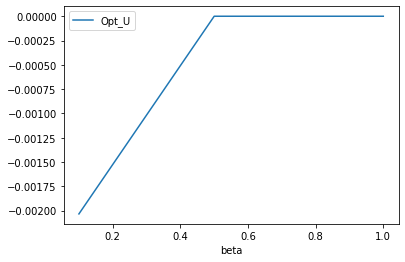

In [11]:
df[df['A']==137.45][df['k']==1.5][df['sigma']==2][['Opt_U', 'beta']].plot('beta', 'Opt_U')